In [1]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Input, Bidirectional, concatenate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import pandas_datareader.data as web
import scipy.stats as scs

Using TensorFlow backend.


In [2]:
df1 = web.get_data_yahoo('spy', start=datetime(1970,1,1))

In [3]:
df = df1.copy()

In [4]:
target_col = 'Close'

close_price = df[target_col].values.reshape(-1, 1)
open_price = df['Open'].values.reshape(-1, 1)

close_price_scaller = MinMaxScaler()
close_price_scalled = close_price_scaller.fit_transform(close_price)

open_price_scaller = MinMaxScaler()
open_price_scalled = open_price_scaller.fit_transform(open_price)

print(close_price_scalled.shape)
print(open_price_scalled.shape)

(7014, 1)
(7014, 1)


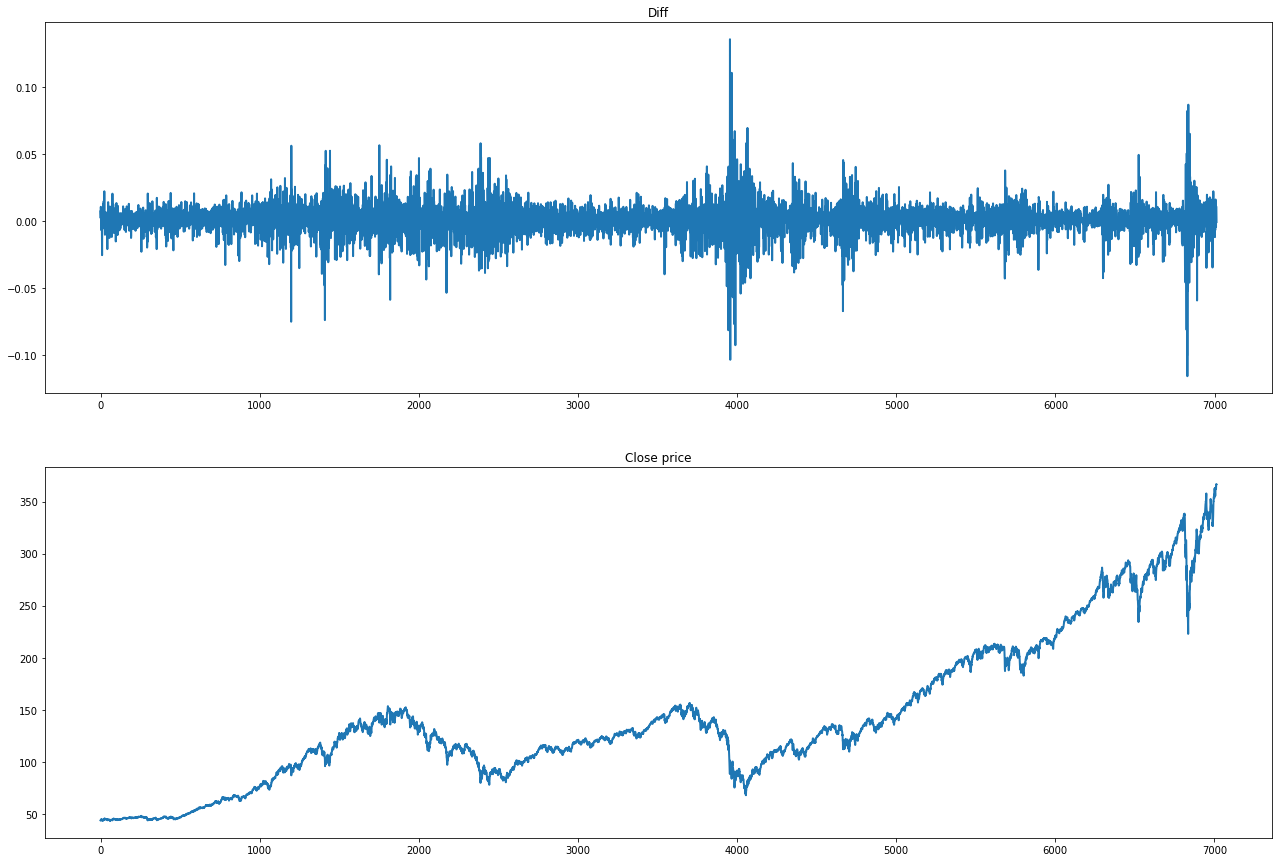

In [5]:
#watch diff log just for records, you can use it in future for classification with predictions
bc_log = pd.DataFrame(np.log(close_price))
log_diff = bc_log.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, figsize=(22, 15))
ax1.set_title('Diff')
ax1.plot(log_diff.values, linewidth=2)
ax2.set_title('Close price')
ax2.plot(close_price, linewidth=2)

In [6]:
def train_test_split(df, test_size=0.5):
    split_row = len(df) - int(test_size * len(df))
    train_data = df[:split_row]
    test_data = df[split_row:]
    return train_data, test_data

In [7]:
train_df, test_df = train_test_split(df, test_size=0.5)

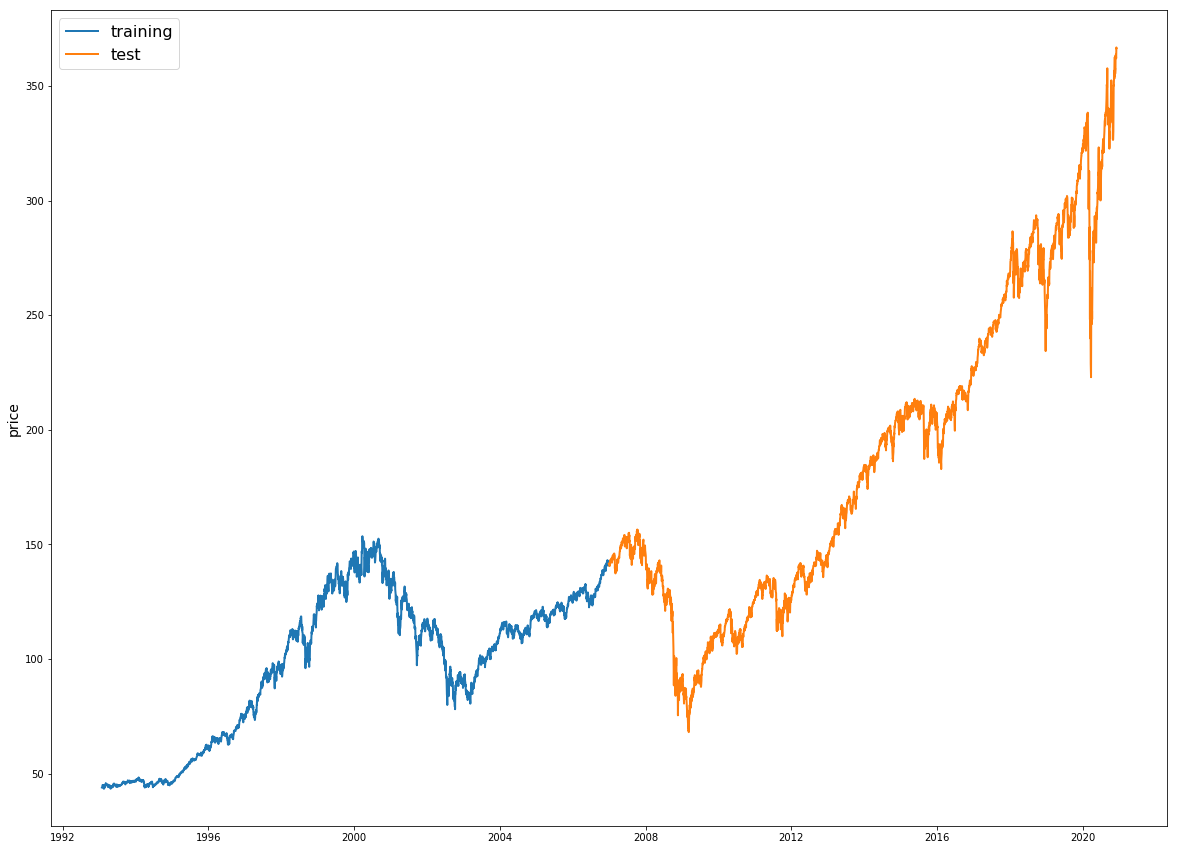

In [8]:
fig, ax = plt.subplots(1, figsize=(20, 15))
ax.plot(train_df[target_col], label='training', linewidth=2)
ax.plot(test_df[target_col], label='test', linewidth=2)
ax.set_ylabel('price', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16);

In [9]:
def accumulate_data(df, window_len):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp)
    return np.array(window_data)

In [10]:
def calc_ema(values, time_period):
    sma = np.mean(values[:, -2])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(len(values) - time_period, len(values)):
        close = values[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

In [11]:
def prepare_data(df, target_col, window_len, test_size):
    scaler = MinMaxScaler()
    scaler_df = scaler.fit_transform(df)
    
    window_data_series = accumulate_data(scaler_df, window_len)
    open_data_series = np.array([open_price_scalled[index] for index in range(window_len, len(open_price_scalled))])
    close_data_series = [close_price_scalled[index] for index in range(window_len, len(close_price_scalled))]
    
    x_train, x_test = train_test_split(window_data_series, test_size)
    x_open_train, x_open_test = train_test_split(open_data_series, test_size)
    y_train, y_test = train_test_split(close_data_series, test_size)
    
    # macd
    technical_indicators = []
    for volch in accumulate_data(df, window_len):
        sma = np.mean(volch[:, -2])    
        macd = calc_ema(volch, 12) - calc_ema(volch, 26)
        
        std = np.std(volch[:, -2])
        
        upper_band = sma + (std * 2)
        lower_band = sma - (std * 2)
            
        technical_indicators.append(np.array([sma, macd, upper_band, std, lower_band]))

    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = MinMaxScaler()
    tech_ind_scaler = tech_ind_scaler.fit_transform(technical_indicators)
    tech_ind_scaler = np.array([tech_ind_scaler[index] for index in range(len(tech_ind_scaler))])
    x_tech_train, x_tech_test = train_test_split(tech_ind_scaler, test_size)
    
    return x_train, x_test, x_open_train, x_open_test, y_train, y_test, x_tech_train, x_tech_test

In [12]:
def build_lstm_model(input_data, input_indicator_data, input_open_train, output_size, 
                     neurons, dropout, loss, optimizer):
    # define three sets of inputs with differents input sizes
    lstm_input  = Input(shape=(input_data.shape[1], input_data.shape[2]), name='lstm_input')
    tech_input = Input(shape=(input_indicator_data.shape[1], ), name='tech_input')
    open_input = Input(shape=(input_open_train.shape[1], ), name='open_input')

    x = Bidirectional(LSTM(neurons, name='lstm_0'))(lstm_input)
    x = Dropout(dropout, name='lstm_dropout_0')(x)
    lstm_branch = Model(inputs=lstm_input, outputs=x)

    y = Dense(units=output_size, name='tech_dense_1')(tech_input)
    y = Activation("relu", name='tech_relu_1')(y)
    y = Dropout(dropout, name='tech_dropout_1')(y)
    technical_indicators_branch = Model(inputs=tech_input, outputs=y)
    
    z = Dense(units=output_size, name='tech_dense_2')(open_input)
    z = Activation("relu", name='tech_relu_2')(z)
    z = Dropout(dropout, name='tech_dropout_2')(z)
    open_branch = Model(inputs=open_input, outputs=z)
    
    # combine the output of the three branches
    combined = concatenate([lstm_branch.output, technical_indicators_branch.output, open_branch.output], name='concatenate')

    z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
    z = Dense(1, activation="linear", name='dense_out')(z)

    # our model will accept the inputs of the two branches and then output a single value
    model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input, open_branch.input], outputs=z)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [13]:
window_len = 50
test_size = 0.2
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [14]:
x_train, x_test, x_open_train, x_open_test, y_train, y_test, x_tech_train, x_tech_test = prepare_data(df.values, target_col, window_len, test_size)

print(x_train.shape)
print(x_test.shape)
print(x_open_train.shape)
print(x_open_test.shape)
print(x_tech_train.shape)
print(x_tech_test.shape)

(5572, 50, 6)
(1392, 50, 6)
(5572, 1)
(1392, 1)
(5572, 5)
(1392, 5)


In [15]:
y_train = np.array(y_train).reshape(1, -1).squeeze()
y_test = np.array(y_test).reshape(1, -1).squeeze()

print(y_train.shape)
print(y_test.shape)

(5572,)
(1392,)


In [ ]:
model = build_lstm_model(x_train, x_tech_train, x_open_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(x=[x_train, x_tech_train, x_open_train], y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.05)

W1203 13:58:09.450237 4677623232 deprecation_wrapper.py:119] From /Users/georgedrimba/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1203 13:58:09.532223 4677623232 deprecation_wrapper.py:119] From /Users/georgedrimba/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1203 13:58:09.540050 4677623232 deprecation_wrapper.py:119] From /Users/georgedrimba/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1203 13:58:10.666797 4677623232 deprecation_wrapper.py:119] From /Users/georgedrimba/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

Train on 5293 samples, validate on 279 samples
Epoch 1/20
5293/5293 [==============================] - 22s 4ms/step - loss: 0.0096 - val_loss: 1.1476e-04
Epoch 2/20
5293/5293 [==============================] - 14s 3ms/step - loss: 2.5915e-04 - val_loss: 9.3428e-05
Epoch 3/20
5293/5293 [==============================] - 13s 2ms/step - loss: 2.1275e-04 - val_loss: 6.0069e-05
Epoch 4/20
5293/5293 [==============================] - 15s 3ms/step - loss: 1.8854e-04 - val_loss: 9.2963e-05
Epoch 5/20
3776/5293 [====================>.........] - ETA: 5s - loss: 1.6830e-04

In [ ]:
preds = model.predict([x_test, x_tech_test, x_open_test]).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
open_real_normallized = close_price_scaller.inverse_transform(x_open_test.reshape(-1, 1))
close_real_normallized = close_price_scaller.inverse_transform(y_test.reshape(-1, 1))
close_pred_normallized = close_price_scaller.inverse_transform(preds.reshape(-1, 1))

fig, ax = plt.subplots(1, figsize=(60, 15))
ax.plot(close_real_normallized, label='actual', linewidth=2)
ax.plot(close_pred_normallized, label='prediction', linewidth=2)
ax.set_ylabel('price', fontsize=14)
ax.set_title('title', fontsize=16)
ax.legend(loc='best', fontsize=16);

In [ ]:
# Daily RSE 
(((close_real_normallized - close_pred_normallized)**2).mean())**0.5

In [ ]:
def calculate_profit():
    balance = 10000
    balance_story = []

    for i, (open_price, close_price, pred) in enumerate(zip(open_real_normallized, close_real_normallized, pred_bi_direct)):
        if i == 0:
            continue
        total_delta = close_price - open_price
        price_range = int(np.round(total_delta.squeeze(), 2) * 100)

        if pred > 0 and price_range > 0:
            balance = balance + price_range
            balance_story.append(balance)
        elif pred > 0 and price_range <= 0:
            balance = balance - abs(price_range)
            balance_story.append(balance)

        if pred < 0 and price_range < 0:
            balance = balance + abs(price_range)
            balance_story.append(balance)
        elif pred < 0 and price_range >= 0:
            balance = balance - abs(price_range)
            balance_story.append(balance)

    return balance_story

In [ ]:
pred_bi_direct =[0]
for index in range(1, len(close_pred_normallized)):
    prev_pred = close_pred_normallized[index-1]
    pred = close_pred_normallized[index]
    delta_pred = prev_pred - pred
    pred_bi_direct.append(1 if delta_pred < 0 else -1)

balance_story = calculate_profit()

fig, ax = plt.subplots(1, figsize=(22, 15))
ax.plot(balance_story, label='balance', linewidth=2)
ax.set_ylabel('profit', fontsize=14)
ax.set_title('trade stock', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [ ]:
close_pred_normallized

In [ ]:
balance = 10000
crets=balance_story.copy()
crets.insert(0,balance)
crets = np.array(crets)
r = crets[1:]-crets[:-1]
log_rets = np.log(crets[1:]/crets[:-1])
rets = (crets[1:]-crets[:-1])/crets[:-1]

import scipy.stats as scs
(log_rets.mean()/scs.tstd(log_rets))* np.sqrt(252)

In [ ]:
pred_bi_direct =[0]
for index in range(1, len(close_pred_normallized)):
    prev_pred = close_pred_normallized[index-1]
    pred = close_pred_normallized[index]
    delta_pred = prev_pred - pred
    pred_bi_direct.append(-1 if delta_pred < 0 else 1)

balance_story = calculate_profit()

fig, ax = plt.subplots(1, figsize=(22, 15))
ax.plot(balance_story, label='balance', linewidth=2)
ax.set_ylabel('profit', fontsize=14)
ax.set_title('trade stock', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [ ]:
#stat test
drets = log_rets - log_rets.mean()
boot_means = []
for _ in range(1000000):
    bootsample = np.random.choice(drets,size=len(drets), replace=True)
    boot_means.append(bootsample.mean())
bootmean = np.mean(boot_means)
bootstd = np.std(boot_means)

In [ ]:
import seaborn as sns
sns.set_style("dark")
plt.hist(boot_means, 50)

In [ ]:
#p value
np.array([1 if x >log_rets.mean() else 0 for x in boot_means]).sum()/len(boot_means)